# Task 2 : Building the baseline model

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, optimizers
import itertools
import math

from funcs_Task1 import training_data_Pipeline, test_validation_data_Pipeline, test_data_Pipeline_non_normalized
from funcs_Task2_3 import plot_accuracy_loss, concat_generators, plot_confusion_matrix

In [2]:
# constants
img_height = img_width = 128
batch_size = 128
img_size = (img_height, img_width)

train_dir = 'covid xray/train'
val_dir = 'covid xray/val'
test_dir = 'covid xray/test'

epochs = 30

### 1. Set up the classification

In [3]:
# Set random seeds for reproducibility
np.random.seed(123)  
tf.random.set_seed(123) 
tf.keras.utils.set_random_seed(123)

# evaluation metrics
METRICS = ["accuracy"]

### 2. Build initial model


In [4]:
model = models.Sequential()

# Convolutional Part
model.add(layers.Input(shape=(128, 128, 3)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))  
model.add(layers.MaxPooling2D(2, 2))                     
model.add(layers.BatchNormalization())                 
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))                         

# Fully Connected Part
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))          
model.add(layers.Dropout(0.5))                                

# Output layer
model.add(layers.Dense(1, activation='sigmoid'))             

# Compile model
model.compile(optimizer='adam',loss='binary_crossentropy', metrics=METRICS)


model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 63, 63, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     3,686,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,706,049 (14.14 MB)

 Trainable params: 3,705,985 (14.14 MB)

 Non-trainable params: 64 (256.00 B)

### 3. Train your model

In [5]:
# Use existing data pipelines
train_data_gen = training_data_Pipeline(batch_size, img_size, train_dir)
val_data_gen = test_validation_data_Pipeline(batch_size, img_size, test_dir=val_dir, train_dir=train_dir)

# Get sample counts (if not already defined)
total_train = train_data_gen.samples
total_val = val_data_gen.samples

# Compile the model (keep your existing METRICS)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
   metrics=METRICS
)

# Train the model
history = model.fit(
    train_data_gen,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
)


Found 1600 images belonging to 2 classes.
Found 1600 images belonging to 2 classes.
Found 1600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


c:\Users\friev\OneDrive - UGent\MaStat\Big Data Science\Artificial Intelligence\exercises\project\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.5373 - loss: 5.4259 - val_accuracy: 0.4975 - val_loss: 0.6918
Epoch 2/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.5806 - loss: 0.6498 - val_accuracy: 0.6050 - val_loss: 0.6729
Epoch 3/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.6163 - loss: 0.6218 - val_accuracy: 0.5650 - val_loss: 0.6896
Epoch 4/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.6099 - loss: 0.5883 - val_accuracy: 0.5675 - val_loss: 0.6799
Epoch 5/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.6194 - loss: 0.5884 - val_accuracy: 0.5450 - val_loss: 0.6866
Epoch 6/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.6309 - loss: 0.5628 - val_accuracy: 0.5950 - val_loss: 0.6768
Epoch 7/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.6188 - loss: 0.5696 - val_accuracy: 0.6225 - val_loss: 0.6789
Epoch 8/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.6438 - loss: 0.5684 - val_accuracy: 0.6350 - val_loss:

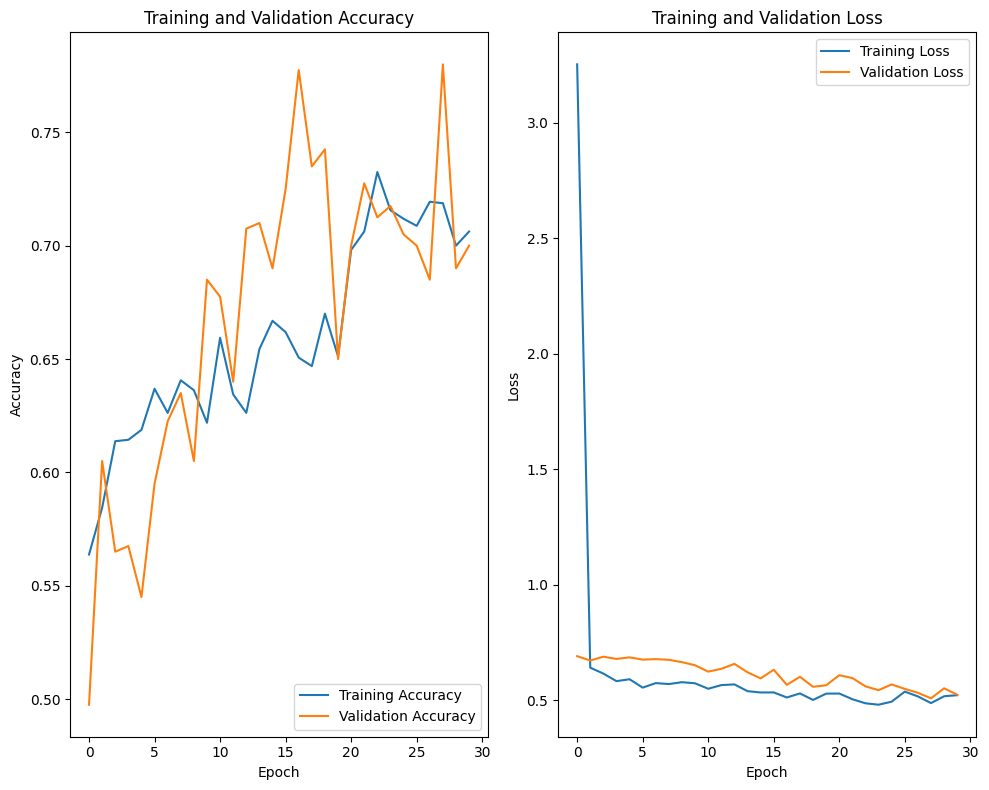

In [6]:
plot_accuracy_loss(history, epochs)

### 4. Hyperparameter tuning

In [7]:
# implementing early stopping
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [8]:
def build_base_model(filter, dropout_rate, optimizer_choice, learning_rate, metrics):

    model = models.Sequential()

    # Convolutional Part
    model.add(layers.Input(shape=(128, 128, 3)))
    model.add(layers.Conv2D(filter, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(2, 2))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(filter, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(2, 2))

    # Fully Connected Part
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(dropout_rate))

    # Output layer
    model.add(layers.Dense(1, activation='sigmoid'))

    # Compile with chosen optimizer and learning rate
    if optimizer_choice == 'adam':
        optimizer = optimizers.Adam(learning_rate=learning_rate)
    else:
        optimizer = optimizers.SGD(learning_rate=learning_rate)

    model.compile(optimizer=optimizer,
                      loss='binary_crossentropy',
                      metrics = metrics)

    return model

In [9]:
# Loop over different combinations of hyperparameters to do grid search

# specify different values of hyperparameters to tune
filters = [8, 32, 64]
dropout_rate = [0.4, 0.3, 0.2]
learning_rate = [1e-3, 1e-4, 1e-5]
optimizer_choice = ['adam', 'sgd']


results = []

for comb in itertools.product(filters, dropout_rate, learning_rate, optimizer_choice):
    filter = comb[0]
    dropout_rate = comb[1]
    learning_rate = comb[2]
    optimizer_choice = comb[3]
    print(f'start model with filter: {filter}, dropout rate: {dropout_rate}, learning rate: {learning_rate}, optimizer: {optimizer_choice}')

    # build model en fit model
    model = build_base_model(filter, dropout_rate, optimizer_choice, learning_rate, METRICS)

    history = model.fit(
         train_data_gen,
         batch_size = batch_size, 
         epochs = epochs,
         validation_data = val_data_gen, 
         callbacks = [early_stop],
         verbose = 0
    )

    # Collect results
    best_val_acc = max(history.history['val_accuracy'])
    amount_epochs = max(history.epoch)
    results.append({
        'filter': filter,
        'dropout_rate': dropout_rate,
        'learning_rate': learning_rate,
        'optimizer': optimizer_choice,
        'val_accuracy': best_val_acc,
        'epochs': amount_epochs
    })

    print(f"Done with filter: {filter}, dropout rate: {dropout_rate}, learning rate: {learning_rate}, optimizer: {optimizer_choice}, val_acc={best_val_acc:.4f}, epochs = {amount_epochs}")


df = pd.DataFrame(results)
df.to_csv("hyperparameter_tuning_results_task2_grid.csv", index=False)


start model with filter: 8, dropout rate: 0.4, learning rate: 0.001, optimizer: adam
Done with filter: 8, dropout rate: 0.4, learning rate: 0.001, optimizer: adam, val_acc=0.7950, epochs = 13
start model with filter: 8, dropout rate: 0.4, learning rate: 0.001, optimizer: sgd
Done with filter: 8, dropout rate: 0.4, learning rate: 0.001, optimizer: sgd, val_acc=0.6825, epochs = 29
start model with filter: 8, dropout rate: 0.4, learning rate: 0.0001, optimizer: adam
Done with filter: 8, dropout rate: 0.4, learning rate: 0.0001, optimizer: adam, val_acc=0.8450, epochs = 29
start model with filter: 8, dropout rate: 0.4, learning rate: 0.0001, optimizer: sgd
Done with filter: 8, dropout rate: 0.4, learning rate: 0.0001, optimizer: sgd, val_acc=0.5600, epochs = 29
start model with filter: 8, dropout rate: 0.4, learning rate: 1e-05, optimizer: adam
Done with filter: 8, dropout rate: 0.4, learning rate: 1e-05, optimizer: adam, val_acc=0.7400, epochs = 29
start model with filter: 8, dropout rate

### 5. final baseline

In [10]:
# get data generators and specify hyperparameters (best performing from tuning)
training_data_gen = training_data_Pipeline(128, img_size, train_dir)
val_data_gen = test_validation_data_Pipeline(128, img_size, train_dir, val_dir)
full_data_gen = concat_generators(training_data_gen, val_data_gen)

total_train = train_data_gen.samples + val_data_gen.samples

best_run = df[df.val_accuracy == df.val_accuracy.max()]
learning_rate = best_run.learning_rate.iloc[0]
dropout_rate = best_run.dropout_rate.iloc[0]
filters = best_run['filter'].iloc[0]
optimizer = best_run.optimizer.iloc[0]
epochs = best_run.epochs.iloc[0]
best_val_acc = best_run.val_accuracy.iloc[0]

print(f"Best performing hyperparameters: filters = {filter}, dropout rate = {dropout_rate}, learning rate = {learning_rate}, optimizer = {optimizer}, epochs ran = {amount_epochs}, val_acc={best_val_acc:.4f}")

Found 1600 images belonging to 2 classes.
Found 1600 images belonging to 2 classes.
Found 1600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Best performing hyperparameters: filters = 64, dropout rate = 0.3, learning rate = 0.001, optimizer = adam, epochs ran = 29, val_acc=0.8875


In [11]:
## fit final baseline model
final_baseline_model = build_base_model(filter, dropout_rate, optimizer_choice, learning_rate, METRICS)

history = final_baseline_model.fit(
    full_data_gen,
    batch_size=batch_size,
    steps_per_epoch= math.ceil(total_train / batch_size),
    epochs=epochs
)

Epoch 1/29
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.5743 - loss: 0.7512
Epoch 2/29
16/16 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.7368 - loss: 0.5374
Epoch 3/29
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.7780 - loss: 0.4898
Epoch 4/29
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.7794 - loss: 0.4712
Epoch 5/29
16/16 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.7510 - loss: 0.4689
Epoch 6/29
16/16 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.8078 - loss: 0.4376
Epoch 7/29
16/16 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.7901 - loss: 0.4405
Epoch 8/29
16/16 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.8189 - loss: 0.4164
Epoch 9/29
16/16 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.8159 - loss: 0.4076
Epoch 10/29
16/16 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.8258 - loss: 0.4029
Epoch 11/29
16/16 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.8190 - loss: 0.3823
Epoch 12/29
16/16 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.8169 - lo

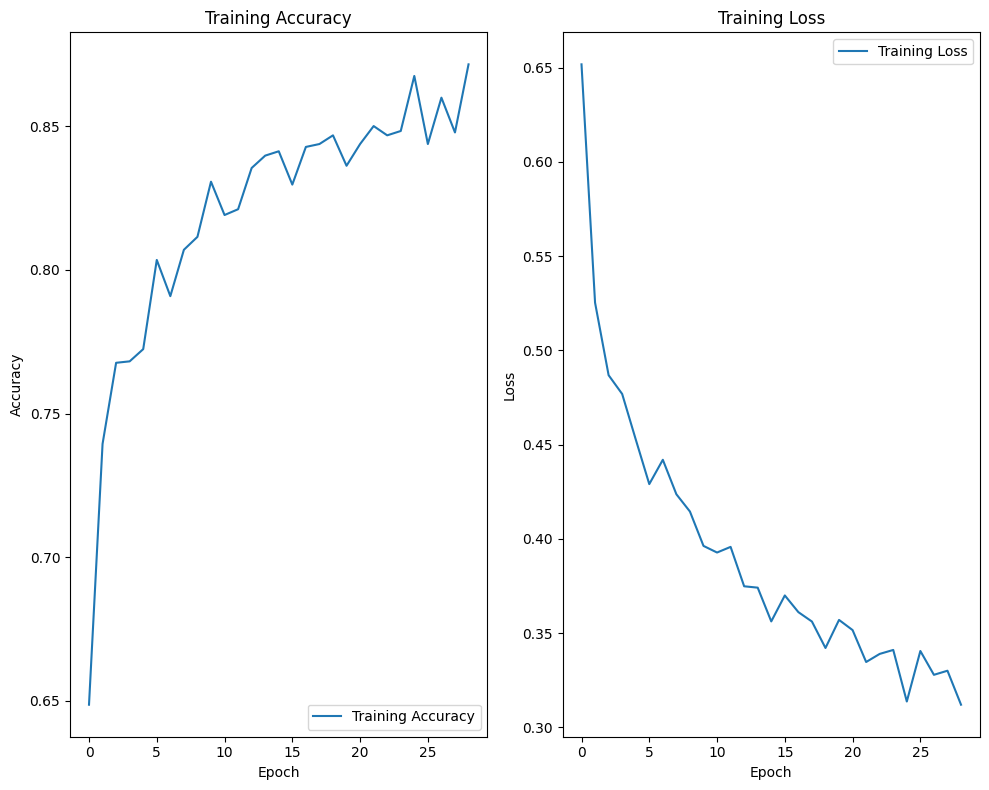

In [12]:
plot_accuracy_loss(history, epochs, validation = False)

In [13]:
# Save the model to disk and load it back
final_baseline_model.save('covid_xray_baseline_model.keras')  # Save the model
loaded_model = tf.keras.models.load_model('covid_xray_baseline_model.keras')  # Load the model

# model evaluation, print performance metrics
test_data_gen = test_validation_data_Pipeline(batch_size, img_size, train_dir, test_dir)
loss, accuracy = loaded_model.evaluate(test_data_gen)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Found 1600 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 318ms/step - accuracy: 0.7726 - loss: 0.4399
Test Loss: 0.4342
Test Accuracy: 0.7800


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 330ms/step


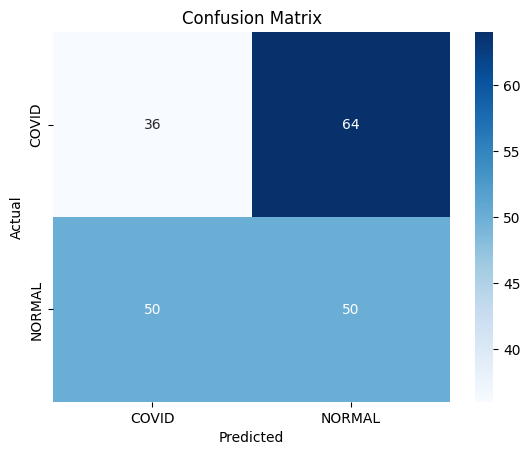

In [14]:
# confusion matrix
y_true = test_data_gen.classes
y_pred_probs = final_baseline_model.predict(test_data_gen)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

plot_confusion_matrix(y_true, y_pred, test_data_gen)

Found 1600 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


c:\Users\friev\OneDrive - UGent\MaStat\Big Data Science\Artificial Intelligence\exercises\project\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/step
Found 200 images belonging to 2 classes.


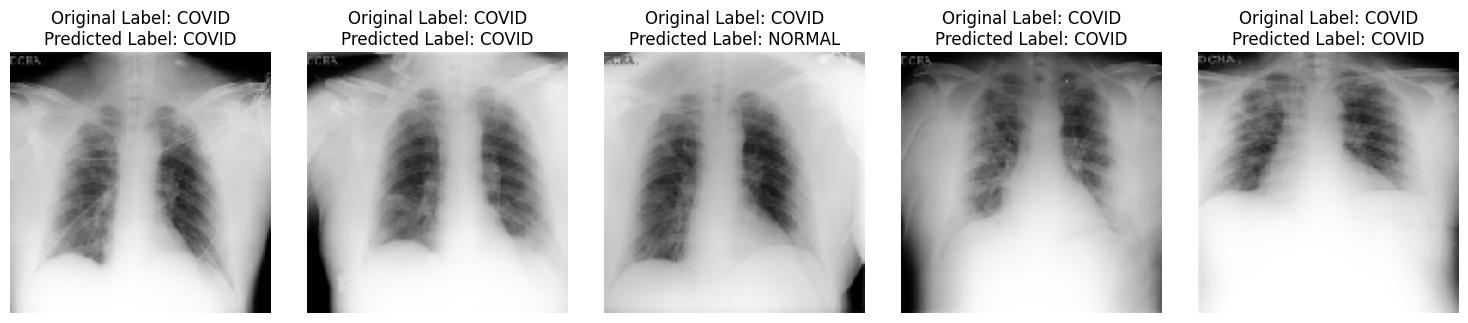

In [ ]:
# Plot a few samples from the test dataset without normalization with evaluation (after normalization)
def get_images_pred_vs_true_label(batch_size, img_size, train_dir, test_dir, model):
# Get batch and process
    ## normalized 
    test_data_gen_normalized  = test_validation_data_Pipeline(batch_size, img_size, train_dir, test_dir, shuffle = False)
    y_pred_probs = model.predict(test_data_gen_normalized)
    y_pred = (y_pred_probs > 0.5).astype(int).flatten()

    ## non-normalized 
    test_data_gen_non_normalized = test_data_Pipeline_non_normalized(batch_size, img_size, test_dir)
    sample_images_non_normalized, sample_labels_non_normalized =  next(test_data_gen_non_normalized)

    ## show figures with labels
    class_names = list(test_data_gen_normalized.class_indices.keys())

    plt.figure(figsize=(15, 6))
    for i, (img, label, pred) in enumerate(zip(sample_images_non_normalized[:5], sample_labels_non_normalized[:5], y_pred[:5])):
        plt.subplot(2, 5, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(f"Original Label: {class_names[int(label)]}\nPredicted Label: {class_names[pred]}"), plt.axis('off')
        
    plt.tight_layout()
    plt.show()

get_images_pred_vs_true_label(batch_size, img_size, train_dir, test_dir, final_baseline_model)